In [1]:
from pickling import load_pickle, create_pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import researchpy as rp
import statsmodels.api as sm
import choplo_statistique as cstats
import choplo_visualization as cvis
from statsmodels.stats.anova import AnovaRM
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison
import os
import statsmodels as sm
import pingouin as pg


In [2]:
a_df = load_pickle('amp')
a_side_df = load_pickle('side_amp')
a_jt_df = load_pickle('amp_jt_new_filt')
a_jt_full_df = load_pickle('amp_not_norm_joint_df_new_filt')
a_angle_full_df = load_pickle('amp_not_norm_angle_df_new_filt')
a_st_df = load_pickle('amp_strat_new_filt')
a_missing_df = load_pickle('missing_amp')

v_df = load_pickle('vit')
v_side_df = load_pickle('side_vit')
v_jt_df = load_pickle('vit_jt_new_filt')
v_st_df = load_pickle('vit_strat_new_filt')
v_jt_full_df = load_pickle('vit_not_norm_joint_df_new_filt')
v_angle_full_df = load_pickle('vit_not_norm_angle_df_new_filt')
v_missing_df = load_pickle('missing_vit') 
idx = pd.IndexSlice


C:\Users\tousi\AppData\Local\conda\conda\envs\python37\lib\site-packages\pandas\core\indexes\base.py:162: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
  return cls.__new__(cls, **d)


In [12]:
a_df.columns.values

array([('start_cm', 'index'), ('start_cm', 'value'), ('rel_pt', 'index'),
       ('rel_pt', 'value'), ('amp_max_cop', 'index'),
       ('amp_max_cop', 'value'), ('amp_max_pel', 'index'),
       ('amp_max_pel', 'value'), ('amp_max_c7', 'index'),
       ('amp_max_c7', 'value'), ('vel_max_cop', 'index'),
       ('vel_max_cop', 'value'), ('vel_max_pel', 'index'),
       ('vel_max_pel', 'value'), ('vel_max_c7', 'index'),
       ('vel_max_c7', 'value'), ('overshoot', 'index'),
       ('overshoot', 'value'), ('dcm', 'index'), ('dcm', 'value'),
       ('dtml', 'index'), ('dtml', 'value'), ('rcm', 'index'),
       ('rcm', 'value')], dtype=object)

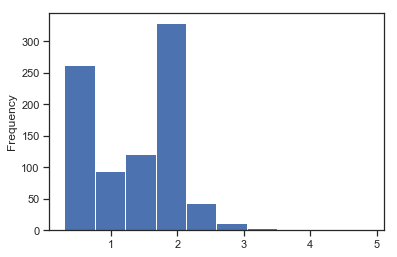

In [11]:
(a_df[('start_cm','index')]/50).plot(kind='hist')

In [3]:
ind0_labels = ["t_r", "cm_max", "tML_max CdP", "tML_max Sb_k", "tML_max Ms_k", "V_max CdP", "V_max Sb_k", "V_max Ms_k", "overshoot", "dcm", "dtml", "rcm"]
ind1_labels = ["(mm)", "(s)"]
multi_index_labels = pd.MultiIndex.from_product([ind0_labels, ind1_labels])

c0_labels_unique = ['Niveau 1', 'Niveau 2', 'Niveau 3', '']
c1_labels_unique = ['Moyenne - (Écart-Type)', 'IC 95%', 'p-value', "Taille de l'effet (n sq)"]
multi_col_labels = pd.MultiIndex(levels=[c0_labels_unique, c1_labels_unique], codes=[[0,0,1,1,2,2,3,3],[0,1,0,1,0,1,2,3]])
sup_1 = u'\u00B9'
sup_2 = u'\u00B2'
sup_1_2 = '{}{}{}'.format(sup_1,u"\u207B",sup_2)
output_string = "{mu}\u00B1{std} {sup}"


def index_to_sec(x, fs=50):
    return x/fs

def meter_to_millimeter(x):
    return x*100

def convert_value(x,v,h):
    if v != 'rcm':
        x = index_to_sec(x) if h=='index' else meter_to_millimeter(x)
    return x

def format_float(f, fs=50, optimatize_dec=True, max_dec=5):
    
    #remove decimal
    if optimatize_dec:
        dec = 1
        while abs(f) < 1/(10**dec):
            dec+=1
            if dec == max_dec:
                break
    else:
        dec = max_dec
    
                
    if abs(f) < 1/(10**max_dec):
        sign = 1 if f >= 0 else -1
        f_round = '<{}'.format(sign/(10**max_dec))
    else:
        f_round = '{0:.{decimal}f}'.format(f, decimal=dec)
    
    return f_round    

def get_formatted_output(data, aov_tbl, id_lvl, hue, var, grpby_var = 'level'):
    
    cnt = data.groupby(grpby_var).count().iloc[id_lvl][0]
    
    mean= data.groupby(grpby_var).mean().iloc[id_lvl][0] # sample mean
    mean = convert_value(mean, var, hue)
    mean_formatted = format_float(mean, hue, optimatize_dec=True, max_dec=5)
    
    std= data.groupby(grpby_var).std().iloc[id_lvl][0]
    std = convert_value(std,var,hue)
    std_formatted = format_float(std, hue, optimatize_dec=True, max_dec=5)
    
    ic_l = mean - (1.96 * (std/np.sqrt(cnt-1)))
    ic_l_formatted = format_float(ic_l, hue,  optimatize_dec=True, max_dec=5)
    
    ic_u = mean + (1.96 * (std/np.sqrt(cnt-1)))
    ic_u_formatted = format_float(ic_u, hue, optimatize_dec=True, max_dec=5)

    return mean_formatted, std_formatted, ic_l_formatted, ic_u_formatted

def format_supscript_posthoc(c0vsc1:bool, c0vsc2:bool, c1vsc2:bool, lvl:str):
    sup_1 = u'\u00B9'
    sup_2 = u'\u00B2'
    sup_1_2 = '{}{}{}'.format(sup_1,u"\u207B",sup_2)
    
    sup = ''
    if lvl=='lvl_1':
        if c0vsc1:
            sup=sup_1

    if lvl=='lvl_2':
        if c0vsc2 and c1vsc2:
            sup=sup_1_2
        else:
            if c0vsc2:
                sup=sup_1
            elif c1vsc2:
                sup=sup_2  
    return sup

def calculate_omega_effect_size(aov):
    "https://en.wikipedia.org/wiki/Effect_size#Omega-squared_(%CF%892)"
    SS_var, df_var, MS_err, SS_total = aov['SS'][0], aov['DF'][0], aov['MS'][1], sum(aov['SS'])
    w_sq = (SS_var - (df_var*MS_err))/(SS_total + MS_err)
    return w_sq
    


In [10]:
def create_anova_table_and_export(df, condition):

    ind0 = ["start_cm", "rel_pt", "amp_max_cop", 'amp_max_pel', 'amp_max_c7', "vel_max_cop", 'vel_max_pel',
                           'vel_max_c7', "overshoot", "dcm", "dtml", "rcm"]
    output_string = "{mu}\u00B1{std} {sup}"
    ic95_string = "[{l_ic} ; {u_ic}]"
    ind1 = ['value','index']
    multi_index = pd.MultiIndex.from_product([ind0, ind1])
    c0_unique = ['lvl_0', 'lvl_1', 'lvl_2', '']
    c1_unique = ['mean_std', 'ic', 'p', 'es']
    multi_col = pd.MultiIndex(levels=[c0_unique,c1_unique], codes=[[0,0,1,1,2,2,3,3],[0,1,0,1,0,1,2,3]])

    nrow = len(ind0) * len(ind1)
    ncol = 8

    data = np.empty((nrow, ncol))
    data[:] = np.nan

    df_output = pd.DataFrame(data, index=multi_index, columns=multi_col)
    num_lvl=3
    for v in ind0:
        for h in ind1:
            #perform stats
            data = cstats.get_data_for_anova(df, v, h) #df with cols players, var, level
            data=data.reset_index()
            data.rename({'index':'subject'},axis=1,inplace = True)
            aov_tbl = pg.rm_anova(data, dv=v, subject='subject',within='level', detailed=True, correction=True)
            mc = pg.pairwise_ttests(v, within='level', subject='subject', data = data, padjust='fdr_bh', effsize='cohen')
            w_sq = round(aov_tbl.iloc[0][8],3)
            p_val = aov_tbl.iloc[0][5]
            if p_val < 0.05:   
                post_hoc = mc['p-corr']
                c0vsc1 = post_hoc[0] < 0.05 
                c0vsc2 = post_hoc[1] < 0.05 
                c1vsc2 = post_hoc[2] < 0.05 
            else:
                c0vsc1 = False 
                c0vsc2 = False 
                c1vsc2 = False



            #fetch data that will be used in output df
            df_output.loc[idx[v,h],idx['','p']] = format_float(p_val, optimatize_dec=False, max_dec=3) #p-value of anova
            df_output.loc[idx[v,h],idx['','es']] = format_float(w_sq, optimatize_dec=True, max_dec=3) #effect size of anova (omega sq) because it is unbiased

            for lvl in list('lvl_{}'.format(i) for i in range(0,num_lvl)): # ['lvl_0','lvl_1',...'lvl_{num_lvl-1}']
                sup=format_supscript_posthoc(c0vsc1,c0vsc2,c1vsc2,lvl)

                id_lvl = int(lvl[-1]) # last string from 'lvl_{i}'
                mean, std, l_ic, u_ic = get_formatted_output(data, aov_tbl, id_lvl, h, v)
                df_output.loc[idx[v,h],idx[lvl,'mean_std']] = output_string.format(mu=mean,std=std,sup=sup) #format string to write in df_output
                df_output.loc[idx[v,h],idx[lvl,'ic']] = ic95_string.format(l_ic=l_ic, u_ic=u_ic)



    df_output.index = multi_index_labels
    df_output.columns = multi_col_labels
    # df_output.reset_index(inplace=True)
    # new_index = df_output.level_0 + ' ' + df_output.level_1
    # df_output.index = new_index
    # df_output.drop(labels=['level_0','level_1'], axis = 1, inplace=True)
    # df_output.to_excel('{}_table_stats.xlsx'.format(condition))

    spatial = df_output.loc[idx[:, '(mm)'],:]
    spatial.reset_index(inplace=True)
    new_index = spatial.level_0 + ' ' + spatial.level_1
    spatial.index = new_index
    spatial.drop(labels=['level_0', 'level_1'], axis=1, inplace=True)

    temporal = df_output.loc[idx[:, '(s)'],:]
    temporal.reset_index(inplace=True)
    new_index = temporal.level_0 + ' ' + temporal.level_1
    temporal.index = new_index
    temporal.drop(labels=['level_0', 'level_1'], axis=1, inplace=True)


    with pd.ExcelWriter('table_stats_{}.xlsx'.format(condition)) as writer:
        spatial.to_excel(writer, sheet_name ="spatial_{}".format(condition))
        temporal.to_excel(writer, sheet_name ="temporal_{}".format(condition))

        
        
    return spatial, temporal, df_output

In [11]:
sp_v, tp_v, vit = create_anova_table_and_export(v_df, 'vitesse')
sp_a, tp_a, amp = create_anova_table_and_export(a_df, 'amplitude')


C:\Users\tousi\AppData\Local\conda\conda\envs\python37\lib\site-packages\pandas\core\generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)
C:\Users\tousi\AppData\Local\conda\conda\envs\python37\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [7]:
mc


NameError: name 'mc' is not defined

In [6]:
df = v_df
v = 'rcm'
h = 'value'
data = cstats.get_data_for_anova(df, v, h) #df with cols players, var, level
data=data.reset_index()
data.rename({'index':'subject'},axis=1,inplace = True)
aov_tbl = pg.rm_anova(data, dv=v, subject='subject',within='level', detailed=True, correction=True)
mc = pg.pairwise_ttests(v, within='level', subject='subject', data = data, padjust='fdr_bh', effsize='cohen')
w_sq = round(calculate_omega_effect_size(aov_tbl),3)
p_val = aov_tbl.iloc[0][5]


In [9]:
aov_tbl = pg.rm_anova(data, dv=v, subject='subject',within='level', detailed =True, correction=True)
aov_tbl

KeyError: 0

In [11]:
ind0 = ["start_cm", "rel_pt", "amp_max_cop", 'amp_max_pel', 'amp_max_c7', "vel_max_cop", 'vel_max_pel',
                           'vel_max_c7', "overshoot", "dcm", "dtml", "rcm"]
ind1 = ['index', 'value']

In [16]:
def create_df_post_hoc(df, h):
    ind0 = ["start_cm", "rel_pt", "amp_max_cop", 'amp_max_pel', 'amp_max_c7', "vel_max_cop", 'vel_max_pel',
                           'vel_max_c7', "overshoot", "dcm", "dtml", "rcm"]
    pieces = {}
    for v in ind0:
        data = cstats.get_data_for_anova(df, v, h) #df with cols players, var, level
        data=data.reset_index()
        data.rename({'index':'subject'},axis=1,inplace = True)
        mc = pg.pairwise_ttests(v, within='level', subject='subject', data = data, padjust='fdr_bh', effsize='cohen')

        pieces[v] = mc
    df = pd.concat(pieces)
    
    return df
        

In [21]:
v_sp = create_df_post_hoc(v_df, 'value')   
v_tmp = create_df_post_hoc(v_df, 'index') 
a_sp = create_df_post_hoc(a_df, 'value') 
a_tmp = create_df_post_hoc(a_df, 'index') 

with pd.ExcelWriter('post_hoc.xlsx') as writer:
    v_sp.to_excel(writer, sheet_name='vitesse_spatial')
    v_tmp.to_excel(writer, sheet_name='vitesse_temporel')
    a_sp.to_excel(writer, sheet_name='amplitude_spatial')
    a_tmp.to_excel(writer, sheet_name='amplitude_temporel')




In [18]:
df

Contrast    A    B  Paired  Parametric      T  dof       tail  \
amp_max_c7  0    level  0.0  1.0    True        True  1.935  9.0  two-sided   
            1    level  0.0  2.0    True        True  3.671  9.0  two-sided   
            2    level  1.0  2.0    True        True  3.315  9.0  two-sided   
amp_max_cop 0    level  0.0  1.0    True        True -2.216  9.0  two-sided   
            1    level  0.0  2.0    True        True -2.192  9.0  two-sided   
            2    level  1.0  2.0    True        True -0.499  9.0  two-sided   
amp_max_pel 0    level  0.0  1.0    True        True  3.673  9.0  two-sided   
            1    level  0.0  2.0    True        True  3.662  9.0  two-sided   
            2    level  1.0  2.0    True        True  1.123  9.0  two-sided   
dcm         0    level  0.0  1.0    True        True -3.981  9.0  two-sided   
            1    level  0.0  2.0    True        True -5.055  9.0  two-sided   
            2    level  1.0  2.0    True        True -2.928  9.0  two-sided   
dtml        0    level  0.0  1.0    True        True -3.242  9.0  two-sided   
            1    level  0.0  2.0    True        True -2.869  9.0  two-sided   
            2    level  1.0  2.0    True        True -0.452  9.0  two-sided   
overshoot   0    level  0.0  1.0    True        True  0.451  9.0  two-sided   
            1    level  0.0  2.0    True        True -0.044  9.0  two-sided   
            2    level  1.0  2.0    True        True -0.586  9.0  two-sided   
rcm         0    level  0.0  1.0    True        True -2.278  9.0  two-sided   
            1    level  0.0  2.0    True        True -4.096  9.0  two-sided   
            2    level  1.0  2.0    True        True -3.562  9.0  two-sided   
rel_pt      0    level  0.0  1.0    True        True  4.365  9.0  two-sided   
            1    level  0.0  2.0    True        True  5.459  9.0  two-sided   
            2    level  1.0  2.0    True        True  3.377  9.0  two-sided   
start_cm    0    level  0.0  1.0    True        True  0.397  9.0  two-sided   
            1    level  0.0  2.0    True        True -1.096  9.0  two-sided   
            2    level  1.0  2.0    True        True -1.085  9.0  two-sided   
vel_max_c7  0    level  0.0  1.0    True        True -1.510  9.0  two-sided   
            1    level  0.0  2.0    True        True -0.583  9.0  two-sided   
            2    level  1.0  2.0    True        True  1.294  9.0  two-sided   
vel_max_cop 0    level  0.0  1.0    True        True -3.993  9.0  two-sided   
            1    level  0.0  2.0    True        True -4.311  9.0  two-sided   
            2    level  1.0  2.0    True        True -4.020  9.0  two-sided   
vel_max_pel 0    level  0.0  1.0    True        True -1.131  9.0  two-sided   
            1    level  0.0  2.0    True        True -1.785  9.0  two-sided   
            2    level  1.0  2.0    True        True -1.049  9.0  two-sided   

                  p-unc    p-corr p-adjust    BF10  CLES  cohen  
amp_max_c7  0  0.085024  0.085024   fdr_bh   1.187  0.60  0.333  
            1  0.005150  0.013522   fdr_bh   10.59  0.70  0.676  
            2  0.009015  0.013522   fdr_bh   6.737  0.61  0.308  
amp_max_cop 0  0.053931  0.084155   fdr_bh   1.665  0.55 -0.324  
            1  0.056103  0.084155   fdr_bh   1.616  0.62 -0.423  
            2  0.629932  0.629932   fdr_bh   0.343  0.56 -0.082  
amp_max_pel 0  0.005129  0.007831   fdr_bh  10.626  0.60  0.377  
            1  0.005220  0.007831   fdr_bh  10.474  0.63  0.545  
            2  0.290433  0.290433   fdr_bh   0.514  0.51  0.136  
dcm         0  0.003201  0.004801   fdr_bh  15.614  0.70 -0.851  
            1  0.000686  0.002058   fdr_bh  55.993  0.82 -1.383  
            2  0.016816  0.016816   fdr_bh     4.1  0.64 -0.535  
dtml        0  0.010125  0.027748   fdr_bh   6.138  0.61 -0.445  
            1  0.018498  0.027748   fdr_bh   3.802  0.65 -0.543  
            2  0.662271  0.662271   fdr_bh   0.337  0.52 -0.086  
overshoot   0  0.662887  0.966005 